---
toc: false
page-layout: full
execute: 
  enabled: false
---

# Week 7B<br>Getting Data, Part 2: Working with APIs

- Section 401
- Wednesday, October 18, 2023

**Week #7 Agenda**

**Last time**:

- Introduction to APIs
- Pulling census data and shape files using Python

**Today:**

- Exercise: Lead poisoning in Philadelphia
- Natural language processing via Philly's 311 API
    - Word frequencies
    - Sentiment analysis

In [429]:
# Data analysis
# APIs
import cenpy
import geopandas as gpd
import holoviews as hv
import hvplot.pandas
import numpy as np
import pandas as pd
import pygris
import requests

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt

In [430]:
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = None

## Exercise: lead poisoning in Philadelphia

Let's use demographic census data in Philadelphia by **census tract** and compare to a dataset of childhood lead poisoning. For this exercise, you'll pull data from the Census API and the CARTO API.

### Step 1. Download the demographic data for Philadelphia

- We are going to be examining the percent of the population that identifies as black in each census tract, so we will need:
    - Total population: 'B03002_001E'
    - Non-Hispanic, Black population: 'B03002_004E'
- Use data from the 2021 5-year ACS
- You'll want to use the state --> county --> tract hierarchy , using the `*` operator to get all tracts in Philadelphia county   
- Remember PA has a FIPS code of "42" and Philadelphia County is "101"

### Step 2. Download and merge in the census tract geometries

Use the `pygris.tracts()` function!

### Step 3. Calculate the black percentage

Add a new column to your data called `percent_black`.

**Important:** Make sure you convert the data to floats!

### Step 4. Query the CARTO API to get the childhood lead levels by census tract

- The API documentation for this data is here: [https://cityofphiladelphia.github.io/carto-api-explorer/#child_blood_lead_levels_by_ct](https://cityofphiladelphia.github.io/carto-api-explorer/#child_blood_lead_levels_by_ct)
- You'll need the API endpoint for CARTO and the name of the table to build your `q` request parameter

### Step 5. Remove census tracts with missing lead measurements

See the `.dropna()` function and the `subset=` keyword.

### Step 6. Merge the demographic and lead level data frames

- From the lead data, we only need the 'census_tract' and 'perc_5plus'. Before merging, trim your data to only these columns.
- You can perform the merge by comparing the `census_tract` and `GEOID` fields
- Remember: when merging, the left data frame should be the GeoDataFrame — use `GeoDataFrame.merge(...)`

### Step 7. Trim to the columns we need

We only need the 'geometry', 'percent_black', and 'perc_5plus', and 'NAME_x' columns

### Step 8. Plot the results

Make two plots:

1. A two panel, side-by-side chart showing a choropleth of the lead levels and the percent black
1. A scatter plot showing the percentage 

You can make these using hvplot or geopandas/matplotlib — whichever you prefer!

### Step 9 (Challenge): Use seaborn to plot a 2d density map

In the previous plots, it's still hard to see the relationship. Use the `kdeplot()` function in `seaborn` to better visualize the relationship.

You will need to remove any NaN entries first.

You should see two peaks in the distribution clearly now!

## API Example #2: Philly 311

Today, we'll pull data using the API for the Philly 311 system, available at: [https://iframe.publicstuff.com/#?client_id=242](https://iframe.publicstuff.com/#?client_id=242)

We saw this site previously when we talked about web scraping last week:

![](imgs/philly-311.png)

Let's take another look at the address where the site is pulling its data from:

`https://vc0.publicstuff.com/api/2.0/requests_list?client_id=242&device=iframe&limit=35&page=1`


This is just an **API request!** It's an example of a *non-public, internal* API, but we can reverse-engineer it to extract the data we want!

Break it down into it's component parts:

- **Base URL:** [https://vc0.publicstuff.com/api/2.0/requests_list](https://vc0.publicstuff.com/api/2.0/requests_list)
- **Query parameters:** client_id, device, limit, page

It looks likes "client_id" identifies data for the City of Philadelphia, which is definitely a required parameter. Otherwise, the other parameters seem optional, returning the requests on a certain device and viewing page.

Let's test it out. We'll grab 2 requests from the first page:

In [23]:
r = requests.get(
    "https://vc0.publicstuff.com/api/2.0/requests_list",
    params={"client_id": 242, "page": 1, "limit": 2},
)

json = r.json()

json

{'response': {'requests': [{'request': {'primary_attachment': {'id': 4616237,
      'extension': 'jpg',
      'content_type': 'image/jpeg',
      'url': 'https://d17aqltn7cihbm.cloudfront.net/uploads/572ba867a308f995b8cd6303b1713988',
      'versions': {'small': 'https://d17aqltn7cihbm.cloudfront.net/uploads/small_572ba867a308f995b8cd6303b1713988',
       'medium': 'https://d17aqltn7cihbm.cloudfront.net/uploads/medium_572ba867a308f995b8cd6303b1713988',
       'large': 'https://d17aqltn7cihbm.cloudfront.net/uploads/large_572ba867a308f995b8cd6303b1713988'}},
     'id': 14494693,
     'image_thumbnail': 'https://d17aqltn7cihbm.cloudfront.net/uploads/small_572ba867a308f995b8cd6303b1713988',
     'title': 'Dangerous Sidewalk',
     'description': None,
     'status': 'submitted',
     'address': '2700–2710 E Sergeant St,Philadelphia, PA 19125',
     'location': 'Philadelphia, Pennsylvania',
     'zipcode': '19125',
     'foreign_id': '16303390',
     'date_created': 1697398345,
     'count_

Now we need to understand the structure of the response. First, access the list of requests:

In [24]:
request_list = json["response"]["requests"]

request_list

[{'request': {'primary_attachment': {'id': 4616237,
    'extension': 'jpg',
    'content_type': 'image/jpeg',
    'url': 'https://d17aqltn7cihbm.cloudfront.net/uploads/572ba867a308f995b8cd6303b1713988',
    'versions': {'small': 'https://d17aqltn7cihbm.cloudfront.net/uploads/small_572ba867a308f995b8cd6303b1713988',
     'medium': 'https://d17aqltn7cihbm.cloudfront.net/uploads/medium_572ba867a308f995b8cd6303b1713988',
     'large': 'https://d17aqltn7cihbm.cloudfront.net/uploads/large_572ba867a308f995b8cd6303b1713988'}},
   'id': 14494693,
   'image_thumbnail': 'https://d17aqltn7cihbm.cloudfront.net/uploads/small_572ba867a308f995b8cd6303b1713988',
   'title': 'Dangerous Sidewalk',
   'description': None,
   'status': 'submitted',
   'address': '2700–2710 E Sergeant St,Philadelphia, PA 19125',
   'location': 'Philadelphia, Pennsylvania',
   'zipcode': '19125',
   'foreign_id': '16303390',
   'date_created': 1697398345,
   'count_comments': 0,
   'count_followers': 0,
   'count_supporters'

We need to extract out the "request" key of each list entry. Let's do that and create a DataFrame:

In [25]:
data = pd.DataFrame([r["request"] for r in request_list])

In [26]:
data.head()

,primary_attachment,id,image_thumbnail,title,description,status,address,location,zipcode,foreign_id,date_created,count_comments,count_followers,count_supporters,lat,lon,user_follows,user_comments,user_request,rank,user
0,"{'id': 4616237, 'extension': 'jpg', 'content_t...",14494693,https://d17aqltn7cihbm.cloudfront.net/uploads/...,Dangerous Sidewalk,None,submitted,"2700–2710 E Sergeant St,Philadelphia, PA 19125","Philadelphia, Pennsylvania",19125,16303390,1697398345,0,0,0,39.976053,-75.117885,0,0,0,1,stewart08
1,"{'id': 4616232, 'extension': 'jpg', 'content_t...",14494686,https://d17aqltn7cihbm.cloudfront.net/uploads/...,Abandoned Automobile,None,submitted,"I-95 S,Philadelphia, PA 19125","Philadelphia, Pennsylvania",19125,16303389,1697398188,0,0,0,39.975304,-75.116556,0,0,0,1,


Success! But we want to build up a larger dataset...let's pull data for the first 3 pages of data. This will take a minute or two...

In [220]:
# Store the data we request
data = []

# Total number of pages
total_pages = 3

# Loop over each page
for page_num in range(1, total_pages + 1):
    # Print out the page number
    print(f"Getting data for page #{page_num}...")

    # Make the request
    r = requests.get(
        "https://vc0.publicstuff.com/api/2.0/requests_list",
        params={
            "client_id": 242,  # Unique identifier for Philadelphia
            "page": page_num,  # What page of data to pull
            "limit": 200,  # How many rows per page
        },
    )

    # Get the json
    d = r.json()

    # Add the new data to our list and save
    data = data + [r["request"] for r in d["response"]["requests"]]

# Create a dataframe
data = pd.DataFrame(data)

Getting data for page #1...
Getting data for page #2...
Getting data for page #3...


In [221]:
len(data)

600

In [222]:
data.head()

,id,image_thumbnail,title,description,status,address,location,zipcode,foreign_id,date_created,count_comments,count_followers,count_supporters,lat,lon,user_follows,user_comments,user_request,rank,user,primary_attachment
0,14494934,,Rubbish Collection,The entire block of 900 N Randolph had no tras...,submitted,"920 N Randolph St,Philadelphia, PA 19123","Philadelphia, Pennsylvania",19123,16303417,1697406040,0,0,0,39.967362,-75.146471,0,0,0,1,nxnw450,NaN
1,14494928,https://d17aqltn7cihbm.cloudfront.net/uploads/...,Illegal Dumping,The property is a triplex that doubles as a ai...,submitted,"205 N 63rd St, Philadelphia, PA 19139, USA",,None,16303415,1697405919,0,0,0,39.965960,-75.245815,0,0,0,1,Staceymccoyn,"{'id': 4616349, 'extension': 'jpg', 'content_t..."
2,14494918,https://d17aqltn7cihbm.cloudfront.net/uploads/...,Illegal Dumping,Bagged trash and construction waste next to road,submitted,"7341–7345 Cresheim Rd,Philadelphia, PA 19119","Philadelphia, Pennsylvania",19119,16303414,1697405620,0,0,0,40.058386,-75.196334,0,0,0,1,juliaeastwood,"{'id': 4616346, 'extension': 'jpg', 'content_t..."
3,14494897,,Recycling Collection,Recycling wasnt picked up on 1400 block of Mar...,in progress,"1415 Marlborough St, Philadelphia, PA 19125, USA",,None,16303412,1697404454,1,0,0,39.973031,-75.133405,0,0,0,1,,NaN
4,14494857,,Abandoned Automobile,Chrysler caprice classic brown\nJxe 6446,submitted,"2400 Christian St,Philadelphia, PA 19146","Philadelphia, Pennsylvania",19146,16303408,1697403318,0,0,0,39.942072,-75.182950,0,0,0,1,jonathanklein,NaN


Let's focus on the "description" column. This is the narrative text that the user inputs when entering a 311 request, and it is an example of *semi-structured* data. For the rest of today, we'll focus on how to extract information from semi-structured data.

### Semi-structured data

Data that contains some elements that cannot be easily consumed by computers 

**Examples:** human-readable text, audio, images, etc

### Key challenges

- **Text mining**: analyzing blocks of text to extract the relevant pieces of information
- **Natural language processing (NLP)**: programming computers to process and analyze human languages
- **Sentiment analysis**: analyzing blocks of text to derive the attitude or emotional state of the person

::: {.callout-note}
Twitter is one of the main API examples of semi-structured data, but since Elon Musk overhauled the API access, it's become prohibitively expensive to access (RIP 💀)
:::

To get started, let's remove any requests where the description is missing:

In [223]:
data = data.dropna(subset=["description"])
data_final = data.loc[data["description"] != ""]

In [224]:
# Strip out spaces and convert to a list
descriptions = data_final["description"].str.strip().tolist()

descriptions[:10]

['The entire block of 900 N Randolph had no trash collection on Saturday.',
 'The property is a triplex that doubles as a airbnb. They put garbage bags out everyday not on trash day.',
 'Bagged trash and construction waste next to road',
 'Recycling wasnt picked up on 1400 block of Marlborough',
 'Chrysler caprice classic brown\nJxe 6446',
 'Encampment in the rear of 2033 S, Broad (on Watts street). Area was fenced off. Fences have now been broken into',
 "2840 N Judson St porch is danger of collapse, held up by a board.  ppl in the home dumping construction trash on the corner. Neighbors homes next door is in danger when the porch collapse too.  couldn't load pic.",
 'No parking sign istalled but in the wrong place.  Fire, rescue, and police as well as trash and recycling cannot pass due to the placement.   Please we need this corrected asap',
 'People have broken into the fence behind vacant building and set up an encampment. The high school is literally across the street.',
 'The pa

### Use case #1: calculating word frequencies

An example of **text mining**

#### Text mining and dealing with messy data

Some steps to clean up our text data:

1. Break strings into words
1. Remove capitalization
1. Remove stop words
1. Remove punctuation

**1. Break strings into words**

Use the `.split()` command to break a string into words by splitting on spaces.

In [447]:
example_string = "This is an Example"

example_string.split()

['This', 'is', 'an', 'Example']

In [448]:
descriptions_words = [desc.split() for desc in descriptions]

In [449]:
descriptions_words[0]

['The',
 'entire',
 'block',
 'of',
 '900',
 'N',
 'Randolph',
 'had',
 'no',
 'trash',
 'collection',
 'on',
 'Saturday.']

This is a list of lists, e.g., the first element is a list of words. Let's *flatten* this into a list of just words:

In [450]:
descriptions_words_flat = []

for list_of_words in descriptions_words:
    for word in list_of_words:
        descriptions_words_flat.append(word)

In [451]:
descriptions_words_flat[:10]

['The', 'entire', 'block', 'of', '900', 'N', 'Randolph', 'had', 'no', 'trash']

**2. Convert all words to lower case**

Use `.lower()` makes all words lower cased

In [452]:
descriptions_words_lower = [word.lower() for word in descriptions_words_flat]

In [453]:
descriptions_words_lower[:10]

['the', 'entire', 'block', 'of', '900', 'n', 'randolph', 'had', 'no', 'trash']

In [454]:
len(descriptions_words_lower)

9631

**3. Remove stop words**

Common words that do not carry much significance and are often ignored in text analysis.

We can use the `nltk` package.

The "Natural Language Toolkit" https://www.nltk.org/

Import and download the stop words:

In [455]:
import nltk

nltk.download("stopwords");

[nltk_data] Downloading package stopwords to /Users/nhand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Get the list of common stop words:

In [456]:
stop_words = list(set(nltk.corpus.stopwords.words("english")))

stop_words[:10]

["you've",
 'no',
 're',
 'i',
 'ourselves',
 'aren',
 'after',
 'his',
 'who',
 "mustn't"]

In [457]:
len(stop_words)

179

In [458]:
descriptions_no_stop = [word for word in descriptions_words_lower if word not in stop_words]

In [459]:
len(descriptions_no_stop)

5611

**4. Remove punctuation**

Get the list of common punctuation:

In [460]:
import string

In [461]:
punctuation = list(string.punctuation)

In [462]:
punctuation[:5]

['!', '"', '#', '$', '%']

Remove punctuation from words:

In [463]:
descriptions_final = []

# Loop over all words
for word in descriptions_no_stop:
    
    # Remove any punctuation from the words
    for p in punctuation:
        word = word.replace(p, "")
        
    # Save it if the string is not empty
    if word:
        descriptions_final.append(word)

Convert to a Dataframe with one column:

In [464]:
words = pd.DataFrame({"words": descriptions_final})

In [465]:
words.head()

,words
0,entire
1,block
2,900
3,n
4,randolph


**Calculate the word frequencies** 

Use a pandas groupby and sort to put in descending order:

In [466]:
N = words.groupby("words", as_index=False).size().sort_values("size", ascending=False, ignore_index=True)

The top 15 words by frequency:

In [467]:
top15 = N.head(15)

top15

,words,size
0,street,120
1,trash,110
2,sidewalk,48
3,please,44
4,months,41
5,block,40
6,car,38
7,side,36
8,picked,36
9,property,34


**Plot the frequencies**

Use `seaborn` to plot our DataFrame of word counts...

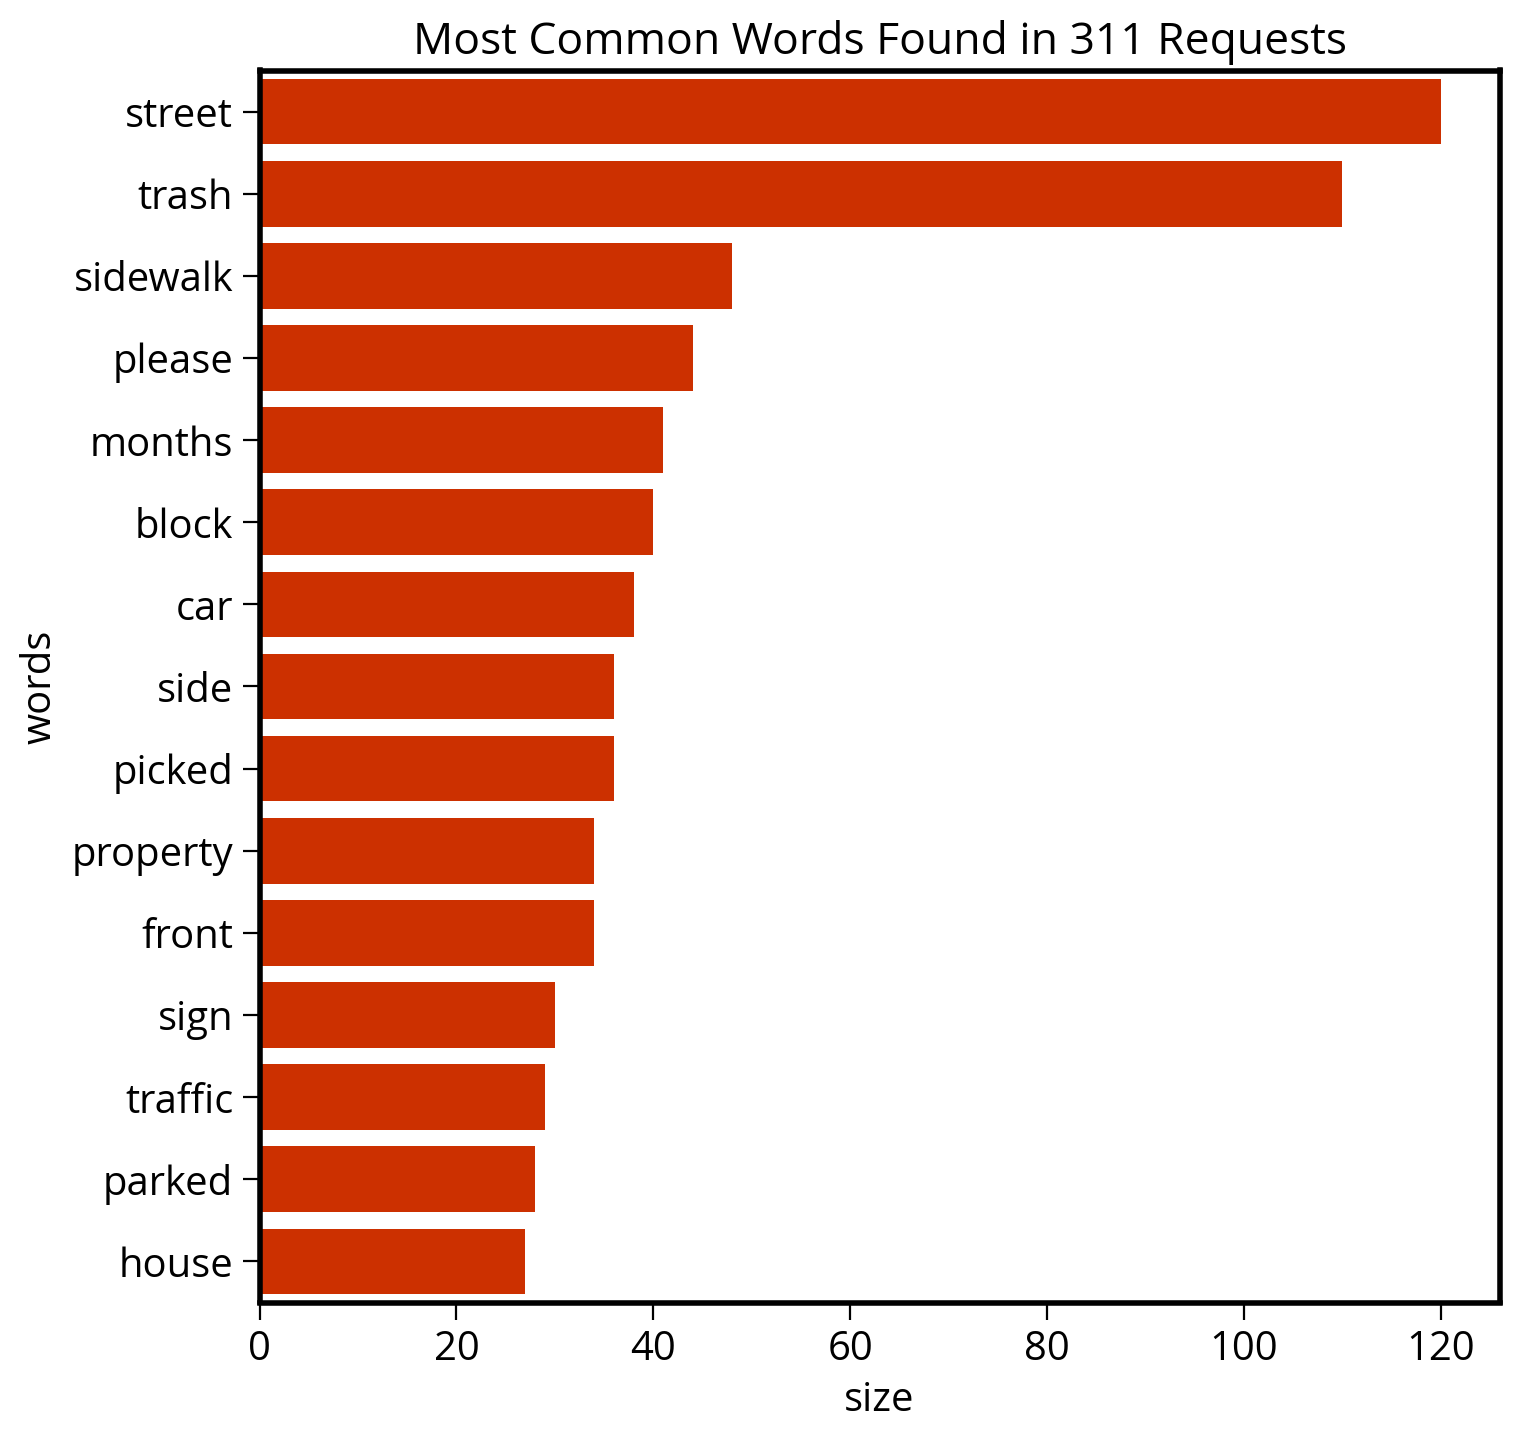

In [468]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
sns.barplot(
    y="words",
    x="size",
    data=top15,
    ax=ax,
    color="#cc3000",
    saturation=1.0,
)

ax.set_title("Most Common Words Found in 311 Requests", fontsize=16);

**Takeaway:** Philly cares about trash! They don't call it Filthadelphia for nothing...

Now, let's visualize with a **word cloud**

Use the [wordcloud](https://amueller.github.io/word_cloud/) package to make a simple word cloud of the word frequencies. 

::: {.callout-note}

We'll need to pass a single string to the WordCloud function. We can combine a list of strings by using the join function and specifying the join separator to be a space (" ")

```python
> strings = ["this", "is", "an", "example"]

> combined_string = " ".join(strings)

> combined_string
'this is an example'
```

:::

In [469]:
from wordcloud import WordCloud

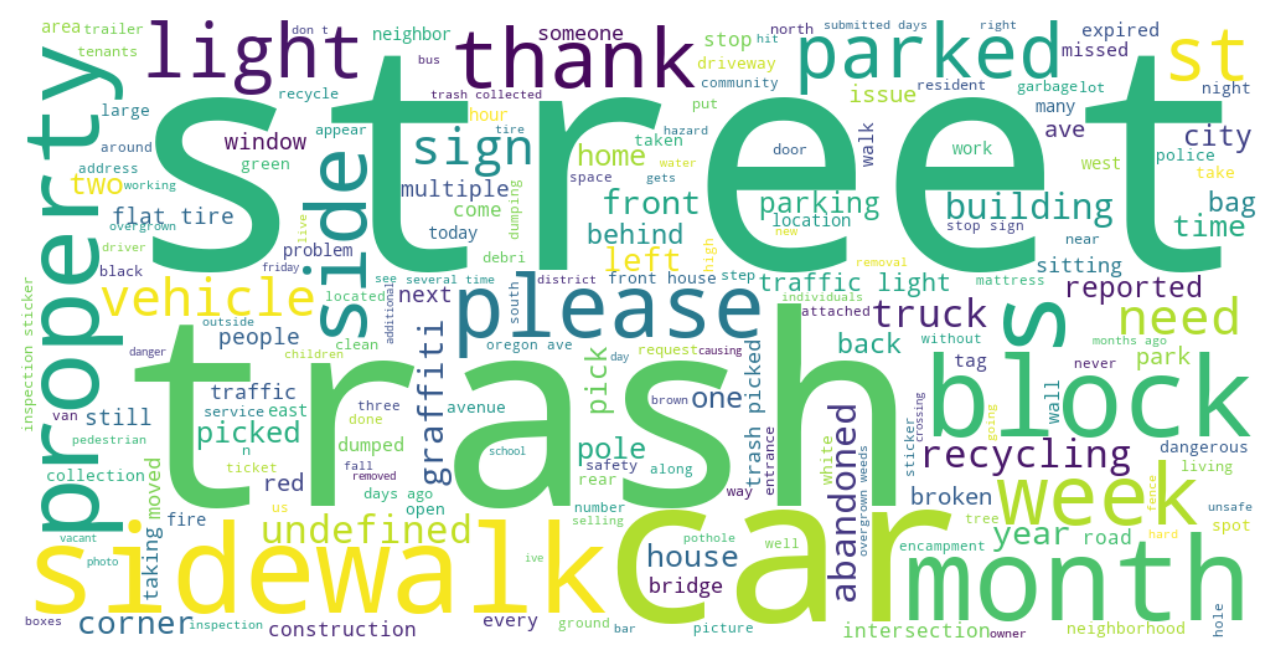

In [470]:
# Create a word cloud object
wc = WordCloud(background_color="white", width=1000, height=500, colormap="viridis")

# Create a single string from all of our descriptions
text = " ".join(descriptions_final)

# Generate the image
img = wc.generate(text)

# The matplotlib fig/ax
fig, ax = plt.subplots()

# Show the image
ax.imshow(img, interpolation="bilinear")

# Format
ax.set_axis_off()
plt.show();

### Use case #2: sentiment analysis

The goal of a **sentiment analysis** is to determine the attitude or emotional state of the person who wrote a piece of text. It is often used by brands to evaluate public opinion about a product. 

**The goal**

Determine the "sentiment" of every word in the English language

**The hard way**

Train a machine learning algorithm to classify words as positive vs. negative, given an input training sample of words.

**The easy way**

Luckily, this is a **very common** task in NLP and there are several packages available that have done the hard work for you. 

They provide out-of-the-box sentiment analysis using pre-trained machine learning algorithms.

#### The `textblob` package

First, let's try out a package called `textblob`. Textblob can calculate the "polarity" of words, from negative -1 to postive +1. 

It's algorithm is not particularly sophisticated (as we will see). It was trained on IMDB movie reviews and uses a dictionary mapping of adjectives to sentiment values. So, it knows about a set of adjectives and an approximate *polarity* for those words. 

Let's try it out on the words from the 311 requests

In [471]:
import textblob

First, copy our "words" dataframe and drop any duplicate words. We'll try to calculate the sentiment for each word.

In [472]:
sentiment = words.copy().drop_duplicates(subset=['words'])

In [473]:
sentiment.head()

,words
0,entire
1,block
2,900
3,n
4,randolph


Now, create our "text blob" objects:

In [474]:
blobs = [textblob.TextBlob(word) for word in sentiment['words']]

Now use the ".polarity" attribute to calculate the sentiment:

In [475]:
sentiment["polarity"] = [blob.polarity for blob in blobs]

In [476]:
sentiment.head(10)

,words,polarity
0,entire,0.0
1,block,0.0
2,900,0.0
3,n,0.0
4,randolph,0.0
5,trash,0.0
6,collection,0.0
7,saturday,0.0
8,property,0.0
9,triplex,0.0


Most of these words are zero!

In [477]:
(sentiment['polarity'] == 0).sum()

1738

In [478]:
len(sentiment)

1878

Why did this happen?

Because the universe of words that TextBlob knows about is pretty small! Mostly confined to common adjectives/adverbs that appeared in its IMDB review dataset.

Let's take a look at the words with nonzero polarity:

In [479]:
sentiment_nonzero = sentiment.query("polarity != 0")

What are the top 15 most positive words?

In [480]:
sentiment_nonzero.sort_values("polarity", ascending=False, ignore_index=True).head(15)

,words,polarity
0,best,1.000000
1,experienced,0.800000
2,fly,0.800000
3,pleasant,0.733333
4,good,0.700000
5,amazing,0.600000
6,hazardous,0.600000
7,rose,0.600000
8,safe,0.500000
9,top,0.500000


What are the top 15 most negative words?

In [481]:
sentiment_nonzero.sort_values("polarity", ascending=True, ignore_index=True).head(15)

,words,polarity
0,outrageous,-1.0
1,worst,-1.0
2,horrible,-1.0
3,terrible,-1.0
4,violent,-0.8
5,afraid,-0.6
6,dangerous,-0.6
7,startling,-0.5
8,illegally,-0.5
9,wrong,-0.5


What about a histogram of the sentiment?

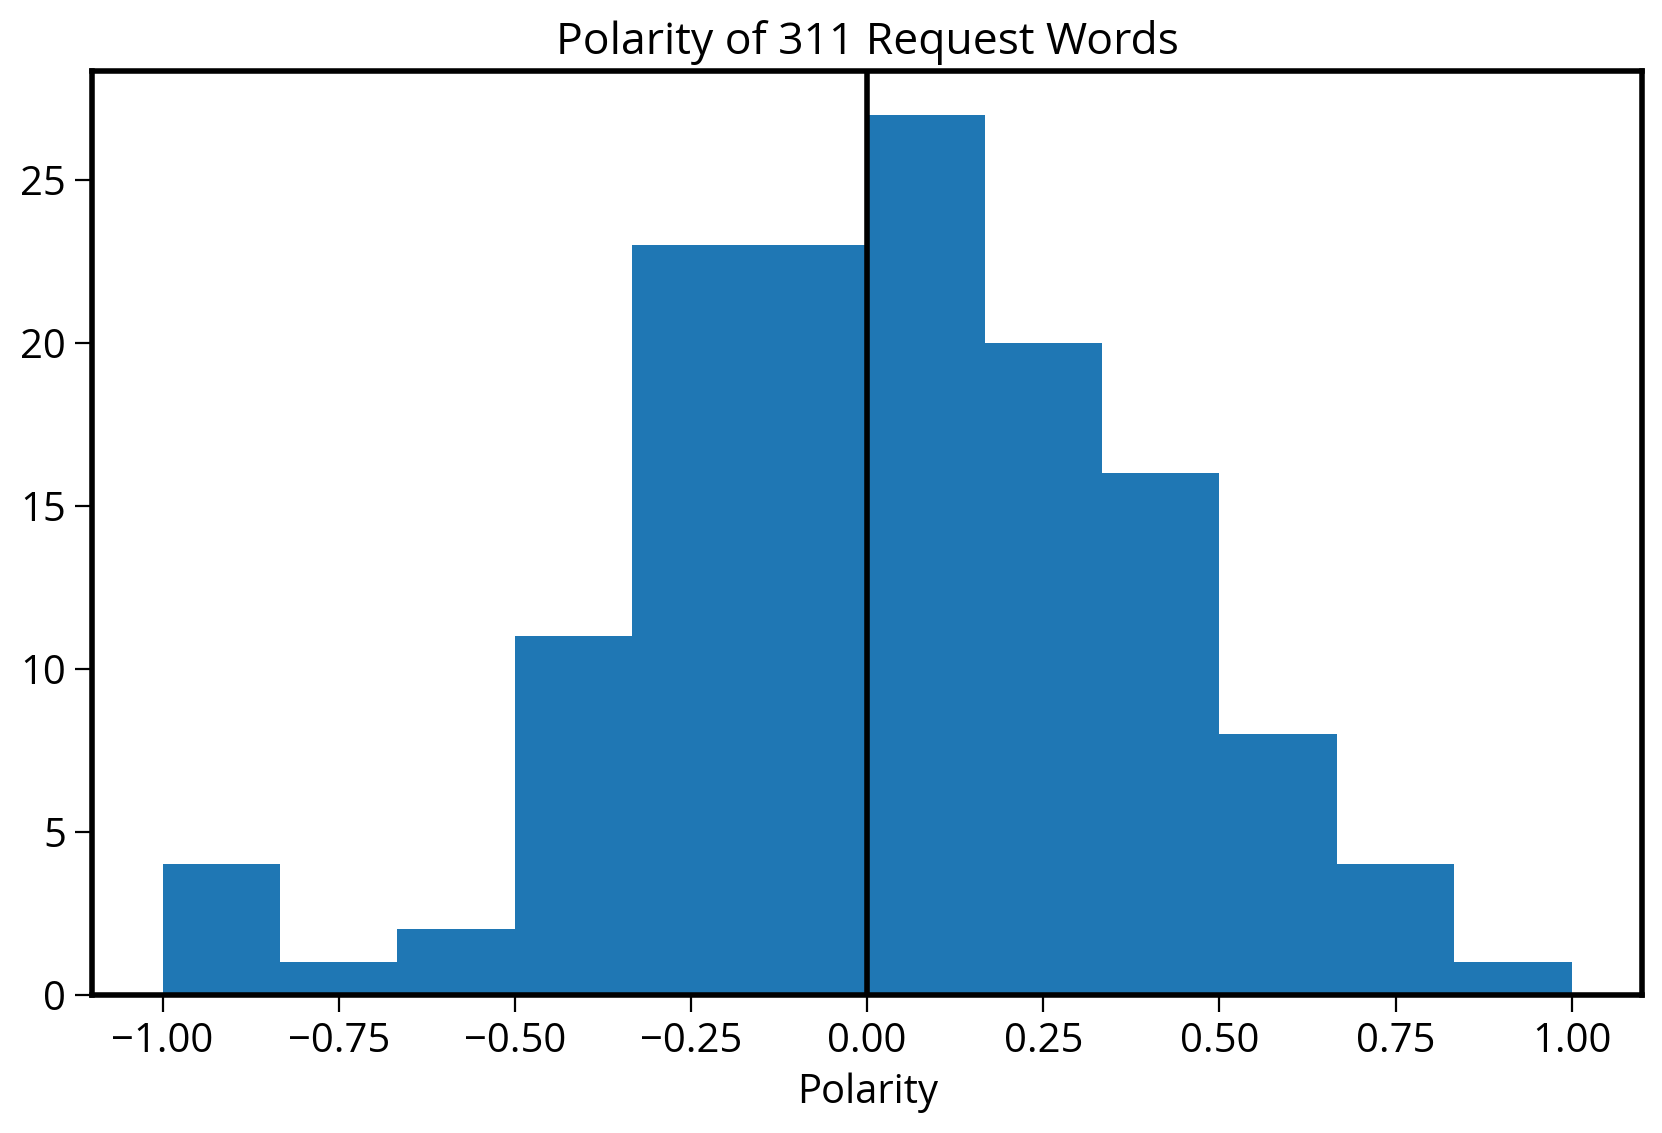

In [482]:
# create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# histogram
ax.hist(sentiment_nonzero["polarity"], bins="auto")
ax.axvline(x=0, c="k", lw=2)

# format
ax.set_xlabel("Polarity")
ax.set_title("Polarity of 311 Request Words", fontsize=16);

Hmm...this is surprising! There are many more positive words than I would have guessed!

**What could be going on?**


Most of the 311 requests are in fact *very* negative. They are mostly complaints, after all.

In the previous analysis, TextBlob only knows the sentiment for a *small* subset of the words. This is makes it difficult to produce a comprehensive sentiment for the entirety of the text for each 311 request. This is difficult because context really matters! Let's see an example:

As you can see in the below example, the negation is not picked up by the algorithm: 

In [483]:
textblob.TextBlob("Philly 311 is the best").polarity

1.0

In [484]:
textblob.TextBlob("Philly 311 is NOT the best").polarity

1.0

Both are marked as positive! (because of the word "best")

Can we do better? YES!

#### The `transformers` package

The Hugging Face `transformers` package ([documentation](https://huggingface.co/docs/transformers/index)) provides access to state-of-the-art, pre-trained machine learning algorithms for natural language processing. 

It provides access to more sophisticated machine learning models that are capable of measuring the sentiment of a piece of text using the full context of the words.



We can use the transformers `pipeline()` function to load and run our pre-trained models

In [485]:
from transformers import pipeline

##### Positive/Negative sentiment analysis

We'll start with a version of the [DistilBERT](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) model that has been fine-tuned on the [Stanford Sentiment Treebank](https://huggingface.co/datasets/sst2) dataset.

For an input series of text, this model will predict the POSITIVE / NEGATIVE labels with associated confidence scores. It will tell us how likely it thinks the text is positive or negative.

::: {.callout-tip}
For more info on sentiment analysis with the `transformers` package, check out this [tutorial](https://huggingface.co/docs/transformers/tasks/sequence_classification).
:::

In [307]:
# The name of the model we are using
model = "distilbert-base-uncased-finetuned-sst-2-english"

# Initialize our sentiment analyzer
sentiment_classifier = pipeline(
    task="sentiment-analysis",  # The task we are doing
    model=model,  # The specific model name
    top_k=None,  # Predict all labels, not just top ones
    tokenizer=model,  # Tokenize inputs using model tokenizer
    truncation=True,  # Truncate text if we need to
)

Now, let's pass our original list of request descriptions to the classifier. 

::: {.callout-note}
We don't need to do any text pre-processing here! We'll just pass in the raw text, so no need to remove stop words, punctuation, etc.
:::


We're now running a much more sophisticated model, so it will take more time to execute! This will likely take 2-3 minutes to run...

In [308]:
%%time

scores = sentiment_classifier(descriptions)

CPU times: user 22min 16s, sys: 9.98 s, total: 22min 26s
Wall time: 2min 44s


What does the response structure look like?

For each description, we get a dictionary containing the label (`POSITIVE` or `NEGATIVE`) and the associated score:

In [309]:
scores[:10]

[[{'label': 'NEGATIVE', 'score': 0.9876556992530823},
  {'label': 'POSITIVE', 'score': 0.01234432402998209}],
 [{'label': 'NEGATIVE', 'score': 0.9566057920455933},
  {'label': 'POSITIVE', 'score': 0.043394193053245544}],
 [{'label': 'NEGATIVE', 'score': 0.9991108775138855},
  {'label': 'POSITIVE', 'score': 0.0008890967001207173}],
 [{'label': 'NEGATIVE', 'score': 0.9974349141120911},
  {'label': 'POSITIVE', 'score': 0.0025651399046182632}],
 [{'label': 'NEGATIVE', 'score': 0.9640655517578125},
  {'label': 'POSITIVE', 'score': 0.035934410989284515}],
 [{'label': 'NEGATIVE', 'score': 0.9928788542747498},
  {'label': 'POSITIVE', 'score': 0.007121145259588957}],
 [{'label': 'NEGATIVE', 'score': 0.9996083378791809},
  {'label': 'POSITIVE', 'score': 0.00039170836680568755}],
 [{'label': 'NEGATIVE', 'score': 0.9989500641822815},
  {'label': 'POSITIVE', 'score': 0.0010499225463718176}],
 [{'label': 'NEGATIVE', 'score': 0.9546453356742859},
  {'label': 'POSITIVE', 'score': 0.04535467550158501}]

Let's unpack this to a more useful format:

In [310]:
yes_no = pd.DataFrame([{d["label"]: d["score"] for d in dd} for dd in s]).assign(
    text=descriptions
)

In [311]:
yes_no.head()

,NEGATIVE,POSITIVE,text
0,0.987656,0.012344,The entire block of 900 N Randolph had no tras...
1,0.956606,0.043394,The property is a triplex that doubles as a ai...
2,0.999111,0.000889,Bagged trash and construction waste next to road
3,0.997435,0.002565,Recycling wasnt picked up on 1400 block of Mar...
4,0.964066,0.035934,Chrysler caprice classic brown\nJxe 6446


**Note:** The scores summed across both labels will sum up to 1. 


**Total sentiment calculation**:
We can calculate the overall score by multiplying the value for each label, e.g., (POSITIVE = +1 and NEGATIVE = -1) by the confidence score for each label. This gives an overall sentiment estimate for each piece of text:

In [323]:
yes_no["sentiment"] = (yes_no["POSITIVE"] * +1) + (yes_no["NEGATIVE"] * -1)

In [324]:
yes_no.head()

,NEGATIVE,POSITIVE,text,sentiment
0,0.987656,0.012344,The entire block of 900 N Randolph had no tras...,-0.975311
1,0.956606,0.043394,The property is a triplex that doubles as a ai...,-0.913212
2,0.999111,0.000889,Bagged trash and construction waste next to road,-0.998222
3,0.997435,0.002565,Recycling wasnt picked up on 1400 block of Mar...,-0.994870
4,0.964066,0.035934,Chrysler caprice classic brown\nJxe 6446,-0.928131


**Question:** Are most of the reviews positive or negative?


Let's take a look at the mean and median:

In [326]:
yes_no['sentiment'].mean()

-0.7430794623687305

In [327]:
yes_no['sentiment'].median()

-0.9914885857142508

Ah! By far, most of these are negative!

Philadelphians using the 311 system appear to be *very* upset.

Let's take a look at the overall histogram of sentiment too. First, we'll need to melt this into a tidy format:

In [330]:
yes_no_tidy = yes_no.melt(
    id_vars=["text"],
    value_vars=["POSITIVE", "NEGATIVE"],
    var_name="emotion",
    value_name="score",
)

In [332]:
yes_no_tidy.head()

,text,emotion,score
0,The entire block of 900 N Randolph had no tras...,POSITIVE,0.012344
1,The property is a triplex that doubles as a ai...,POSITIVE,0.043394
2,Bagged trash and construction waste next to road,POSITIVE,0.000889
3,Recycling wasnt picked up on 1400 block of Mar...,POSITIVE,0.002565
4,Chrysler caprice classic brown\nJxe 6446,POSITIVE,0.035934


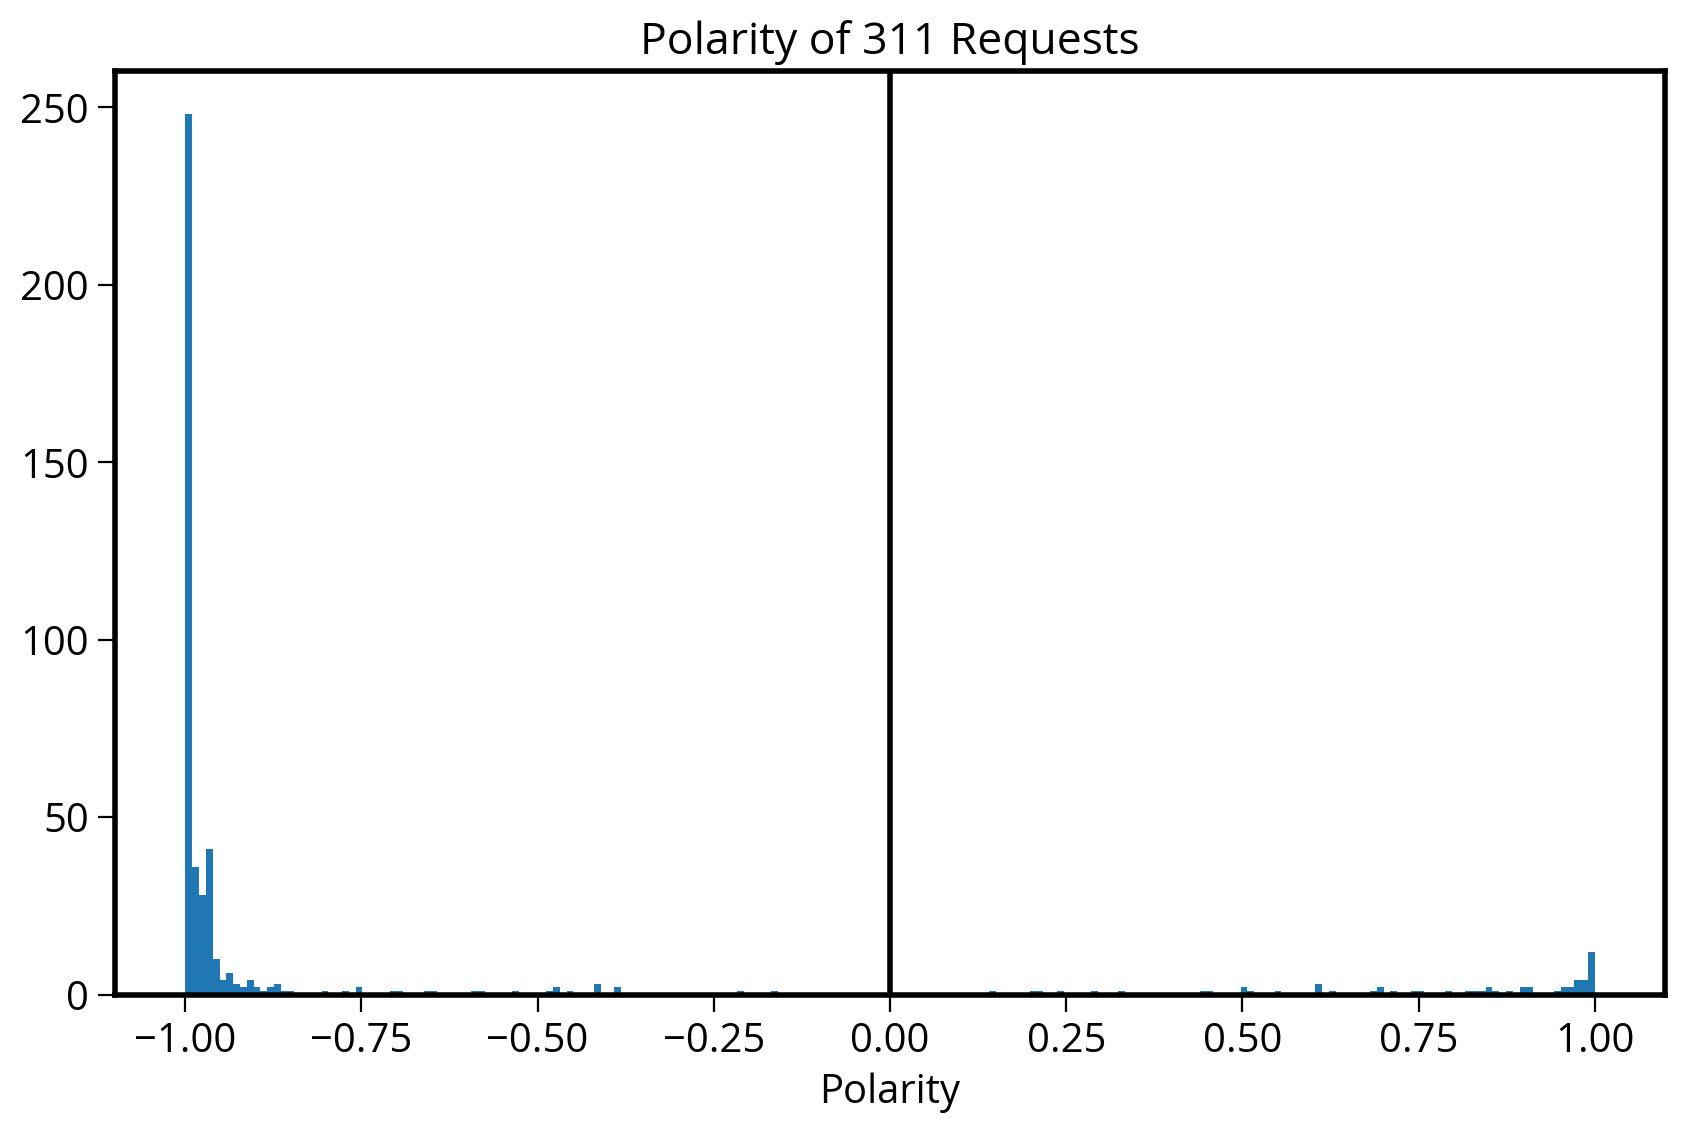

In [333]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
ax.hist(total_sentiment, bins="auto")
ax.axvline(x=0, c="k", lw=2)

# Format
ax.set_xlabel("Polarity")
ax.set_title("Polarity of 311 Requests", fontsize=16);

Whoa! Very negative sentiment!

**This makes much more sense than our earlier results with the Textblob package.**

Let's look at the 10 requests with the lowest sentiment scores:

In [342]:
yes_no.sort_values("sentiment", ascending=True).head(10)

,NEGATIVE,POSITIVE,text,sentiment
117,0.999794,0.000206,Expired tags and appears abandoned,-0.999587
253,0.999787,0.000213,The traffic light at 13th and Oregon is stuck.,-0.999574
454,0.999746,0.000254,Missed collection,-0.999493
128,0.999745,0.000255,The 2nd floor of the 1155 S 9th Street moved out and they dumped their stuff on the sidewalk.,-0.999489
277,0.999743,0.000257,The vehicle has been there for more then 2 weeks. seems to be abandoned,-0.999486
371,0.999742,0.000258,Trash is consistently left at the entrance of Chew playground.,-0.999485
280,0.999740,0.000260,Car has been left for months with 3 flat tires and has not been moved or anyone to repair,-0.999479
468,0.999738,0.000262,"I’ve had issues before with the trash collectors not picking up my trash but this is the worst experience. They opened a bag of my trash and dumped it into the trash can and then left the now half empty trash bag on the ground. So not only did they not take all our trash, they also opened and half emptied a bag of trash that was in our trash can and then left the opened trash in our van and strewn on the sidewalk.",-0.999476
344,0.999736,0.000264,Food cart was dumped in the community garden,-0.999472
256,0.999733,0.000267,ped signal malfunction,-0.999466


And the 10 requests with the highest sentiment:

In [343]:
yes_no.sort_values("sentiment", ascending=False).head(10)

,NEGATIVE,POSITIVE,text,sentiment
43,0.000216,0.999784,Graffiti and sticker on sign. Please and thank you!,0.999567
52,0.000289,0.999711,Graffiti on sign. Please and thank you!,0.999422
53,0.000289,0.999711,Graffiti on sign. Please and thank you!,0.999422
455,0.000533,0.999467,This is the first of three poles in front of 2531 Orthodox that have been tagged with red marker. Thank you.,0.998935
340,0.001060,0.998940,Encampment has doubled in size since initial reporting. Please clear the camp asap and clean up area (trash/needles/human waste/shopping carts/random furniture). Thank you!,0.997880
443,0.001380,0.998620,Graffiti on newspaper bin. Please and thank you!,0.997240
77,0.001807,0.998193,"Everyone trash was picked up except mine, and my trash was at curbside on time. I live at the corner house it’s not hard to miss",0.996387
364,0.001954,0.998046,Big Belly overflowing,0.996092
365,0.001954,0.998046,Big Belly overflowing,0.996092
147,0.002254,0.997746,At the entrance to Magnolia Garden,0.995491


**Takeaway**

The model is still clearly focusing on some crucial words (please, thank you = "positive") but overall, doing a much, much better job overall of understanding the full context of the text. 

##### Emotion sentiment analysis

The `transformers` package also includes pre-trained models that can predict *emotion* labels. As an example, let's try out [this version](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion) of the DistilBERT model that can predict the following labels for a string of text: anger, fear, sadness, joy, love, and surprise.

In [344]:
# The
model = "bhadresh-savani/distilbert-base-uncased-emotion"

# Initialize our sentiment analyzer
emotion_classifier = pipeline(
    task="text-classification",  # The task we are doing
    model=model,  # The specific model name
    top_k=None,  # Predict all labels, not just top ones
    tokenizer=model,  # Tokenize inputs using model tokenizer
    truncation=True,  # Truncate text if we need to
)

Classify the 311 descriptions using our emotions model. Once again, this will likely take 2-3 minutes to run:

In [347]:
%%time 

emotion_scores = emotion_classifier(descriptions)

CPU times: user 24min 6s, sys: 9.65 s, total: 24min 16s
Wall time: 2min 57s


In [348]:
emotion_scores[0]

[{'label': 'anger', 'score': 0.7160319089889526},
 {'label': 'fear', 'score': 0.18108969926834106},
 {'label': 'sadness', 'score': 0.08944033086299896},
 {'label': 'joy', 'score': 0.009873006492853165},
 {'label': 'surprise', 'score': 0.0024349840823560953},
 {'label': 'love', 'score': 0.0011300727492198348}]

Unpack the label/score combos into a DataFrame:

In [349]:
emotion = pd.DataFrame(
    [{d["label"]: d["score"] for d in dd} for dd in emotion_scores]
).assign(text=descriptions)

In [358]:
emotion.head()

,anger,fear,sadness,joy,surprise,love,text
0,0.716032,0.181090,0.089440,0.009873,0.002435,0.001130,The entire block of 900 N Randolph had no trash collection on Saturday.
1,0.960171,0.012939,0.015907,0.009602,0.000799,0.000582,The property is a triplex that doubles as a airbnb. They put garbage bags out everyday not on trash day.
2,0.818394,0.150760,0.022973,0.005217,0.001567,0.001091,Bagged trash and construction waste next to road
3,0.829894,0.053235,0.024447,0.088462,0.002535,0.001426,Recycling wasnt picked up on 1400 block of Marlborough
4,0.096447,0.072743,0.044335,0.768291,0.009970,0.008215,Chrysler caprice classic brown\nJxe 6446


Now, let's calculate the predicted label for each text. This is the label with the highest score for each text.

In [364]:
emotion_labels = ["anger", "fear", "sadness", "joy", "surprise", "love"]

Use the `idxmax()` function to find the column with the maximum value for each row:

In [366]:
emotion[emotion_labels].idxmax(axis=1)

0        anger
1        anger
2        anger
3        anger
4          joy
        ...   
468    sadness
469      anger
470       fear
471      anger
472      anger
Length: 473, dtype: object

In [367]:
emotion['prediction'] = emotion[emotion_labels].idxmax(axis=1)

In [368]:
emotion.head()

,anger,fear,sadness,joy,surprise,love,text,prediction
0,0.716032,0.181090,0.089440,0.009873,0.002435,0.001130,The entire block of 900 N Randolph had no trash collection on Saturday.,anger
1,0.960171,0.012939,0.015907,0.009602,0.000799,0.000582,The property is a triplex that doubles as a airbnb. They put garbage bags out everyday not on trash day.,anger
2,0.818394,0.150760,0.022973,0.005217,0.001567,0.001091,Bagged trash and construction waste next to road,anger
3,0.829894,0.053235,0.024447,0.088462,0.002535,0.001426,Recycling wasnt picked up on 1400 block of Marlborough,anger
4,0.096447,0.072743,0.044335,0.768291,0.009970,0.008215,Chrysler caprice classic brown\nJxe 6446,joy


What's the breakdown across the predicted labels?

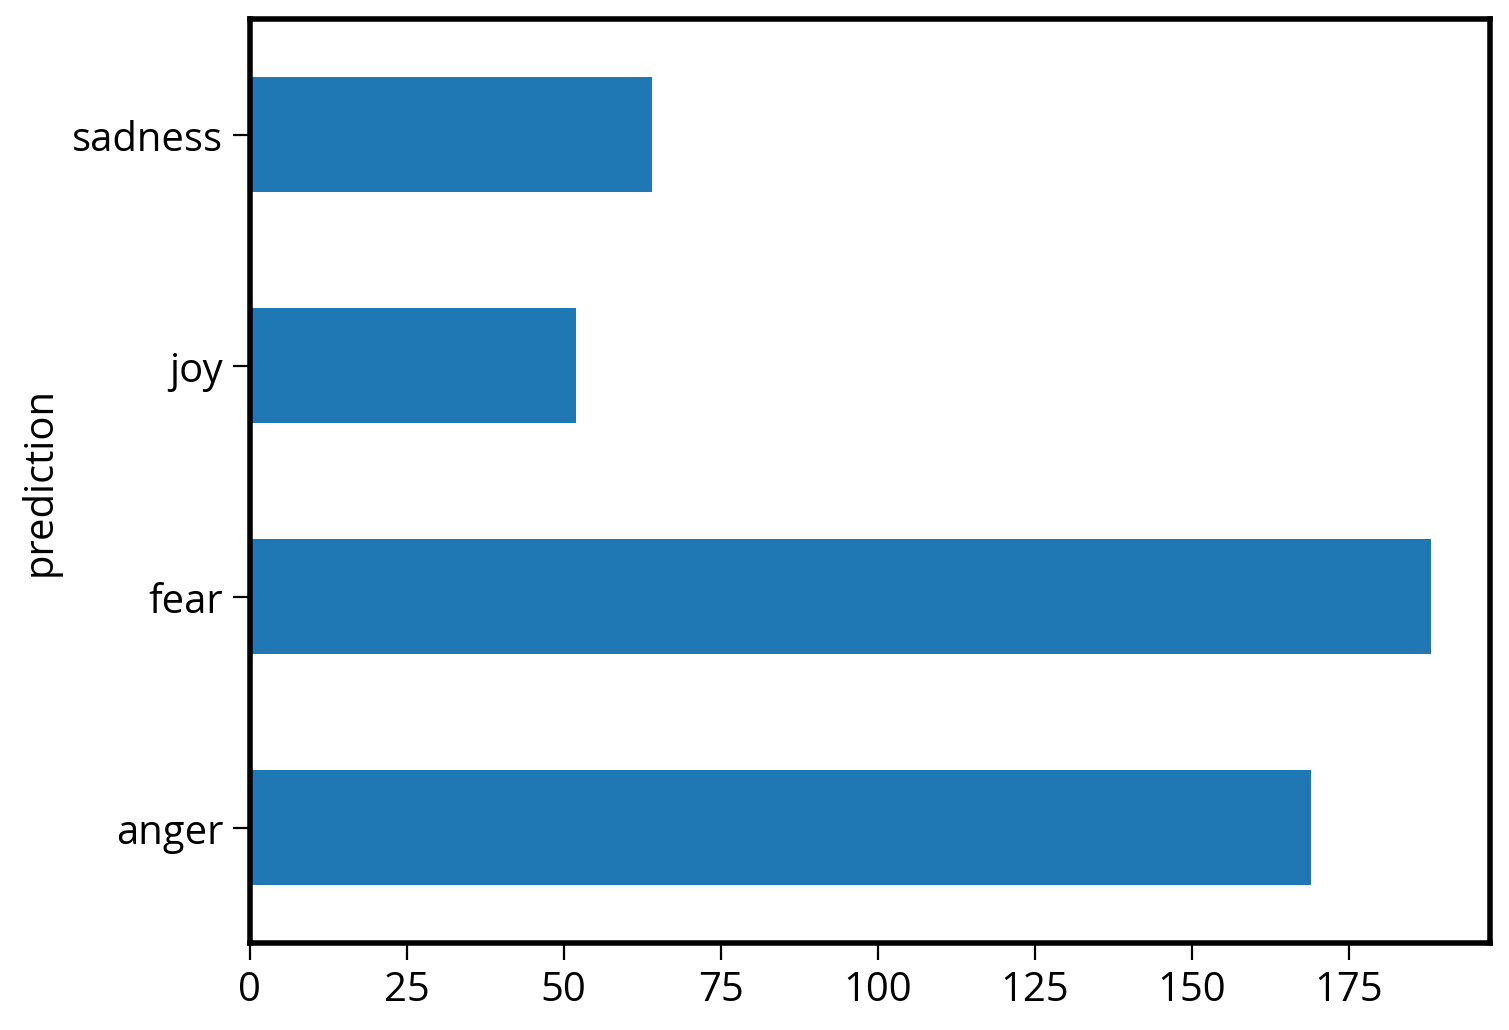

In [374]:
emotion.groupby("prediction").size().plot(kind='barh');

**Takeaway:**  Most descriptions are classified as "fear" or "anger"

How about visualizing the full distribution of scores across all emotions?

Let's get a tidy version for analysis:

In [377]:
emotion_tidy = emotion.melt(
    id_vars=["text"], value_vars=emotion_labels, var_name="emotion", value_name="score"
)

In [379]:
emotion_tidy.head()

,text,emotion,score
0,The entire block of 900 N Randolph had no trash collection on Saturday.,anger,0.716032
1,The property is a triplex that doubles as a airbnb. They put garbage bags out everyday not on trash day.,anger,0.960171
2,Bagged trash and construction waste next to road,anger,0.818394
3,Recycling wasnt picked up on 1400 block of Marlborough,anger,0.829894
4,Chrysler caprice classic brown\nJxe 6446,anger,0.096447


Make a box plot of the distribution across all emotions:

/Users/nhand/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


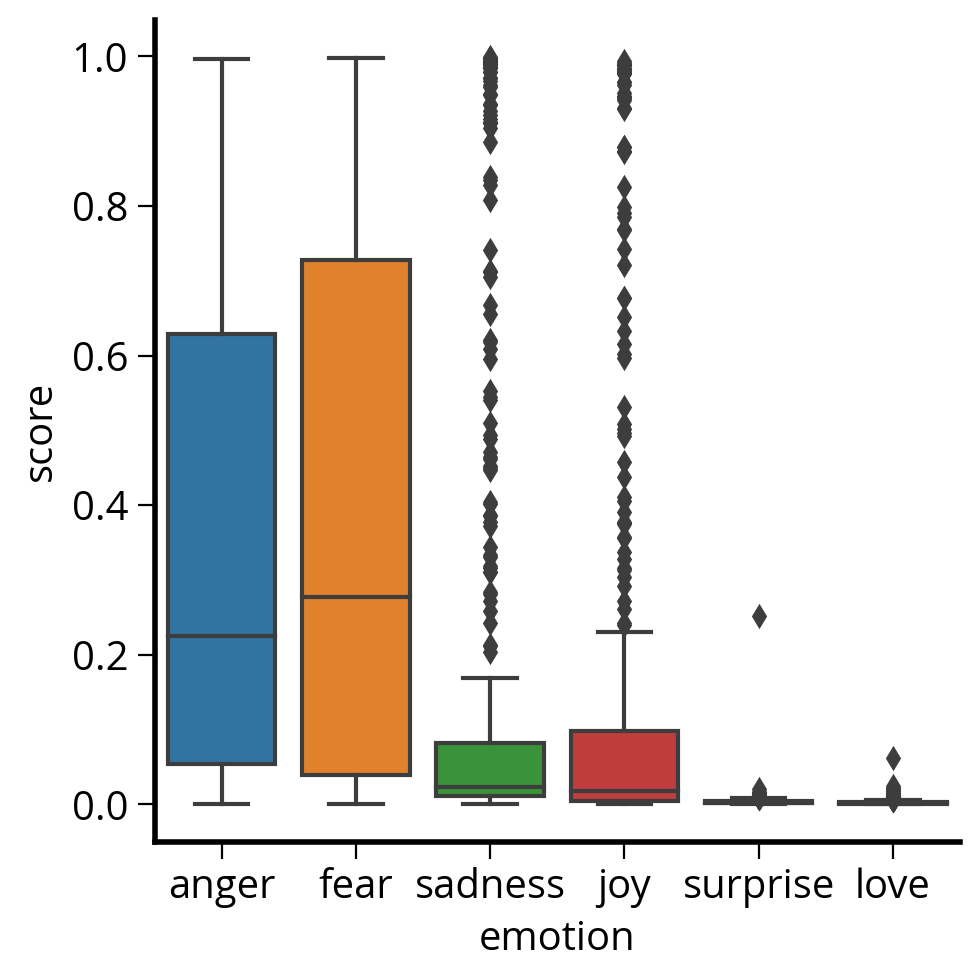

In [380]:
sns.catplot(data=emotion_tidy, x="emotion", y="score", kind="box");

**Takeaway:**

Fear and anger!

Surprise/joy are the least common emotions, with sadness/joy being a bit more common. Anger/fear are by far, the most common emotions. For most emotions other than anger/fear, scores are concentrated near zero, indicating that the text likely does not contain those emotions.

Let's do a deeper dive on some of the emotions:

**Anger**

In [416]:
angry_requests = emotion.query("anger > 0.8").sort_values("anger", ascending=False)

In [417]:
len(angry_requests)

70

In [405]:
angry_requests.head(20)

,anger,fear,sadness,joy,surprise,love,text,prediction
288,0.996761,0.002000,0.000567,0.000295,0.000170,0.000207,"homeless woman has set up home here, very violent, has taken over the park",anger
388,0.995740,0.002679,0.000406,0.000602,0.000215,0.000357,The lights don’t go on when it gets dark it. Very dangerous at this busy intersection.,anger
41,0.995312,0.002940,0.000742,0.000595,0.000163,0.000248,"It is extremely hard to see at night especially since there is not stop sign on the road leading up to it. We hear cars hit it often and it is loud, sometimes flat tires happen and it’s dangerous for electric bikes and scooters.",anger
367,0.991368,0.005699,0.001204,0.000882,0.000370,0.000478,Smelly,anger
138,0.990195,0.007373,0.001310,0.000709,0.000198,0.000215,"Manton St is already a narrow street, the pothole makes trash collection difficult because the trash truck has to reverse and maneuver thru cars that are already parked on the curb, very dangerous",anger
297,0.987678,0.001447,0.010036,0.000509,0.000155,0.000174,This city block and others within the collection truck are kept CLEAN and as LITTER-free as possible. BUT!!!!! After the crew is finished collecting it looks like the trash truck DUMPED his load all the way down the middle of the street. It even addresses and obviously to no avail. The work crew lately are very unprofessional in their task.,anger
413,0.981672,0.007016,0.002928,0.007144,0.000662,0.000578,"Business operating outdoor seating long after permitted hours: in practice, this means large numbers of loud drunks seated in the street at all hours of the night.",anger
391,0.979714,0.013915,0.003317,0.002273,0.000425,0.000357,The trash is never picked up at this Popeyes restaurant location.,anger
188,0.977072,0.002977,0.018333,0.001047,0.000232,0.000340,"My trash collection day is Thursday but due to the holiday, it was Friday. I put my trash out on Friday morning. I return home in the evening and my trash was not picked up. All other trash on my block was picked up except mine. It was one bag, bagged correctly and placed on the sidewalk \n\nI don’t understand why everyone else’s bags were picked up and mine was not. \n\nThis has happened several times this year. It’s unacceptable. I’ve never experienced my trash being left on the sidewalk. There’s a breakdown somewhere and I want answers \n\nI pay taxes like everyone else and I expect the services available to me. \n\nI would like to speak with a supervisor regarding this matter. This is happening one too many times",anger
295,0.975601,0.011817,0.010809,0.001132,0.000411,0.000230,Trash men did not take any of my bags \r\nIf there was a limit why didn’t take any?,anger


And as a word cloud:

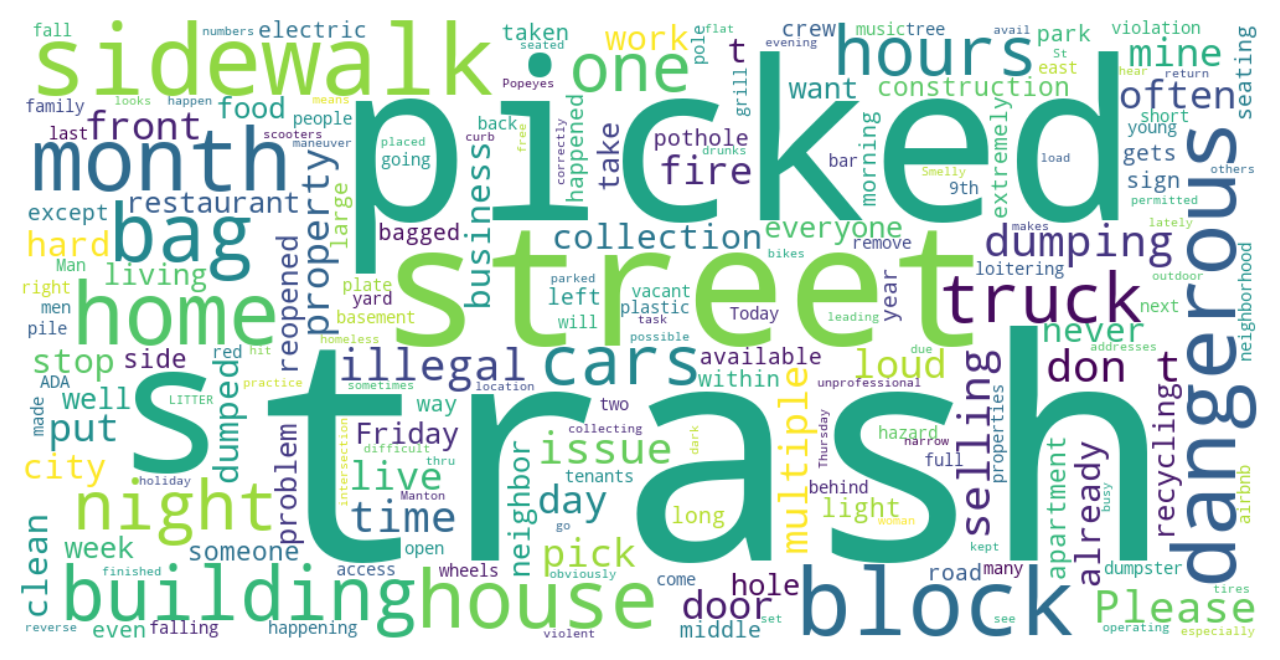

In [406]:
# Create a word cloud object
wc = WordCloud(background_color="white", width=1000, height=500, colormap="viridis")

# Combine the text into a single string
text = " ".join(angry_requests["text"].tolist())

# Generate the image
img = wc.generate(text)


# The matplotlib fig/ax
fig, ax = plt.subplots()

# Show the image
ax.imshow(img, interpolation="bilinear")

# Format
ax.set_axis_off()
plt.show();

**Fear**

And the most fearful:

In [407]:
fearful_requests = emotion.query("fear > 0.8").sort_values("fear", ascending=False)

In [418]:
len(fearful_requests)

76

In [419]:
fearful_requests.head(20)

,anger,fear,sadness,joy,surprise,love,text,prediction
393,0.000993,0.997273,0.000726,0.000412,0.000457,0.000140,"Broken basement window where people and cats are entering and exiting the house. Potential fire hazard when people are entering to get high. I live next door and I’m afraid every day. Complaint previously passed on to Streets Department with no response from that department. Property has been reported since February, 2023.",fear
6,0.004574,0.990393,0.003393,0.000967,0.000470,0.000203,"2840 N Judson St porch is danger of collapse, held up by a board. ppl in the home dumping construction trash on the corner. Neighbors homes next door is in danger when the porch collapse too. couldn't load pic.",fear
363,0.004638,0.985345,0.006113,0.002642,0.000980,0.000282,Facade of building is buckling and appears to be in danger of collapse,fear
69,0.004817,0.982761,0.008939,0.001064,0.002184,0.000234,Wrecked vehicle parked blocking crosswalk and too close to fire hydrant. Possibility of being stolen and abandoned.,fear
231,0.004904,0.982750,0.001458,0.009303,0.000991,0.000594,"Oregon Avenue area from 6th street to broad st, all the traffic lights are on but not working properly. Oregon ave east and west are staying green while the streets entering Oregon avenue are all red. Everyone please be cautious on crossing Oregon Avenue!",fear
382,0.012143,0.982206,0.002702,0.001706,0.000932,0.000311,Individuals are living in the bus shelter.,fear
470,0.015853,0.978478,0.002839,0.001654,0.000914,0.000262,"Street light about to fall on the sidewalk, electrical hazard.",fear
299,0.013964,0.976793,0.004869,0.002986,0.001006,0.000381,Traffic lights are not working at 16th and 15th Oregon Ave.,fear
262,0.016249,0.976393,0.003348,0.002975,0.000777,0.000259,This mattress has been on the ground so long that it looks like it's decomposing. Have reported it several times. Will probably need shovels to remove.,fear
254,0.013346,0.975593,0.003211,0.003480,0.003692,0.000678,exposed concrete at the bottom of the big spiral slide at Starr Garden,fear


And as a word cloud:

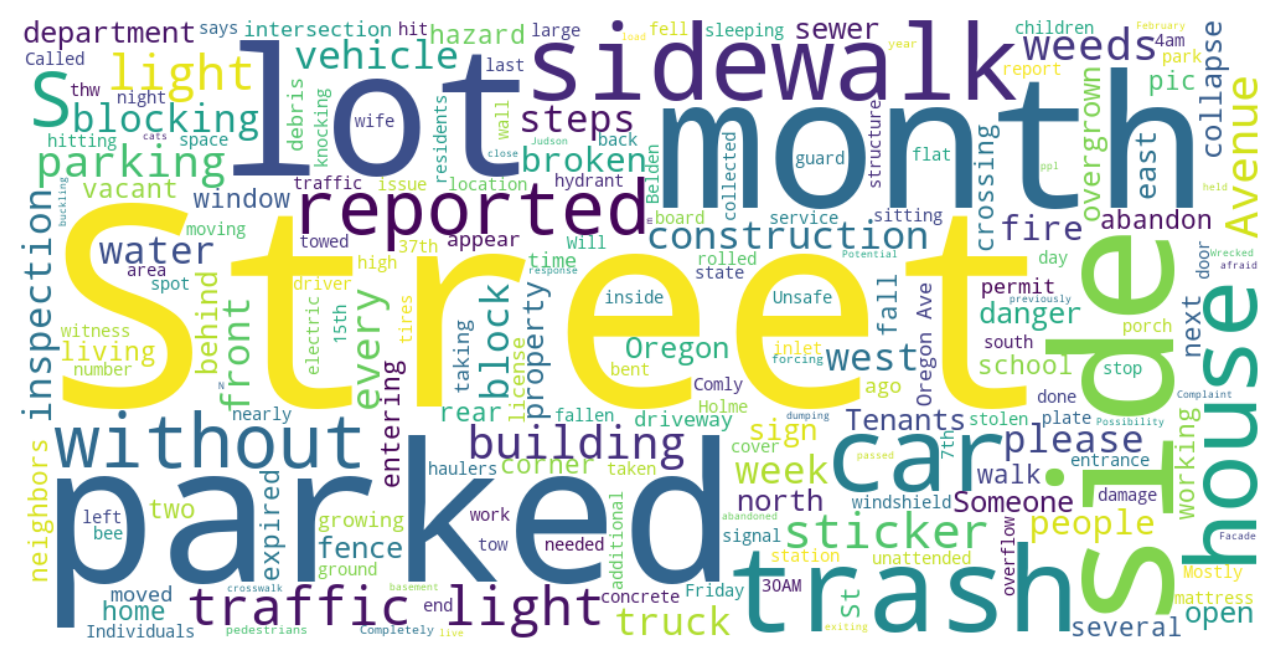

In [420]:
# Create a word cloud object
wc = WordCloud(background_color="white", width=1000, height=500, colormap="viridis")

# Combine the text into a single string
text = " ".join(fearful_requests["text"].tolist())

# Generate the image
img = wc.generate(text)


# The matplotlib fig/ax
fig, ax = plt.subplots()

# Show the image
ax.imshow(img, interpolation="bilinear")

# Format
ax.set_axis_off()
plt.show();

**Takeaway:**

Overall, the algorithm is doing a pretty good job picking up the emotion and sentiment in the requests. 

One potential use case for a model like this: *prioritizing responses*. For example:

- You might want to respond more quickly to those that are classified as the most fearful, given that those situations might be the most dangerous. 
- Or, requests that are classified as the angriest might warrant a closer follow-up from a city representative, since many of these requests are likely repeated requests from frustrated residents.

But, once again, we see the limitations of sentiment analysis as text with words like "thank you" and "please" get classified as positive ("joy"):

In [421]:
joyful_requests = emotion.query("joy > 0.8").sort_values("joy", ascending=False)

Not that many requests!

In [422]:
len(joyful_requests)

29

In [423]:
joyful_requests.head(20)

,anger,fear,sadness,joy,surprise,love,text,prediction
340,0.002017,0.000519,0.002006,0.994091,0.000246,0.001121,Encampment has doubled in size since initial reporting. Please clear the camp asap and clean up area (trash/needles/human waste/shopping carts/random furniture). Thank you!,joy
43,0.001318,0.000329,0.000946,0.990678,0.000373,0.006355,Graffiti and sticker on sign. Please and thank you!,joy
52,0.003696,0.000729,0.001794,0.988631,0.000529,0.004622,Graffiti on sign. Please and thank you!,joy
53,0.003696,0.000729,0.001794,0.988631,0.000529,0.004622,Graffiti on sign. Please and thank you!,joy
455,0.002053,0.000456,0.001143,0.988566,0.000379,0.007404,This is the first of three poles in front of 2531 Orthodox that have been tagged with red marker. Thank you.,joy
185,0.004943,0.000768,0.004332,0.988528,0.000329,0.001101,"Hi i so a resident from 633,634,643 E Thayer st and the people from the garage on F st and Ontario st. And the beauty salon through in trash next to the electricity pole on F st. & Ontario st and they know that the pole have a sign of fine they don’t put a address in the bags because they know they can get a fine",joy
189,0.005435,0.000843,0.004306,0.987868,0.000416,0.001132,No recycle pickup yesterday for the odd numbers side of the block. All recycle bins are at the curbside waiting. Please pick up as a continued effort to keep our City clean.,joy
459,0.003105,0.000685,0.002470,0.984554,0.000512,0.008674,Submitted this 18 days ago ... \r\n\r\nThere are two tags in white marker on the U.S.P.S. mailbox that's on the Bridge Street side of 2634 Bridge (7-11). Thank you.,joy
239,0.006350,0.000603,0.004603,0.982837,0.000506,0.005102,"Sitting here for two weeks, can we get it picked up - thanks",joy
452,0.007622,0.001140,0.001989,0.981206,0.000395,0.007648,I submitted this 18 days ago ...\r\n\r\nThis is the third of three poles in front of 2531 Orthodox that have been tagged with red marker. Thank you.,joy


And as a word cloud:

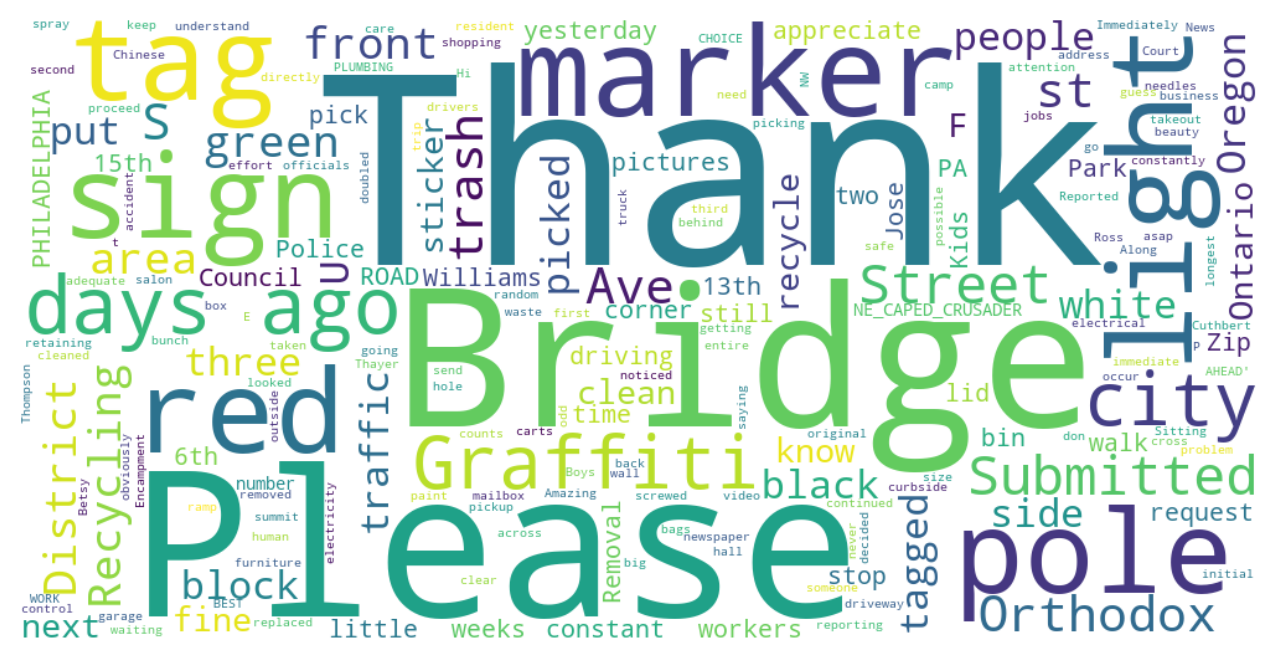

In [424]:
# Create a word cloud object
wc = WordCloud(background_color="white", width=1000, height=500, colormap="viridis")

# Combine the text into a single string
text = " ".join(joyful_requests["text"].tolist())

# Generate the image
img = wc.generate(text)


# The matplotlib fig/ax
fig, ax = plt.subplots()

# Show the image
ax.imshow(img, interpolation="bilinear")

# Format
ax.set_axis_off()
plt.show();

In [355]:
col = "joy"

emotion.query(f"{col} > 0.9").sort_values(col, ascending=False).head(10)

,anger,fear,sadness,joy,surprise,love,text
340,0.002017,0.000519,0.002006,0.994091,0.000246,0.001121,Encampment has doubled in size since initial reporting. Please clear the camp asap and clean up area (trash/needles/human waste/shopping carts/random furniture). Thank you!
43,0.001318,0.000329,0.000946,0.990678,0.000373,0.006355,Graffiti and sticker on sign. Please and thank you!
52,0.003696,0.000729,0.001794,0.988631,0.000529,0.004622,Graffiti on sign. Please and thank you!
53,0.003696,0.000729,0.001794,0.988631,0.000529,0.004622,Graffiti on sign. Please and thank you!
455,0.002053,0.000456,0.001143,0.988566,0.000379,0.007404,This is the first of three poles in front of 2531 Orthodox that have been tagged with red marker. Thank you.
185,0.004943,0.000768,0.004332,0.988528,0.000329,0.001101,"Hi i so a resident from 633,634,643 E Thayer st and the people from the garage on F st and Ontario st. And the beauty salon through in trash next to the electricity pole on F st. & Ontario st and they know that the pole have a sign of fine they don’t put a address in the bags because they know they can get a fine"
189,0.005435,0.000843,0.004306,0.987868,0.000416,0.001132,No recycle pickup yesterday for the odd numbers side of the block. All recycle bins are at the curbside waiting. Please pick up as a continued effort to keep our City clean.
459,0.003105,0.000685,0.002470,0.984554,0.000512,0.008674,Submitted this 18 days ago ... \r\n\r\nThere are two tags in white marker on the U.S.P.S. mailbox that's on the Bridge Street side of 2634 Bridge (7-11). Thank you.
239,0.006350,0.000603,0.004603,0.982837,0.000506,0.005102,"Sitting here for two weeks, can we get it picked up - thanks"
452,0.007622,0.001140,0.001989,0.981206,0.000395,0.007648,I submitted this 18 days ago ...\r\n\r\nThis is the third of three poles in front of 2531 Orthodox that have been tagged with red marker. Thank you.


*Sentiment analysis* -- a helpful, but imperfect analysis tool!

## That's it!

- Next week: working with big (1M+ rows) datasets
- See you on Monday!